In [1]:
#Loading Libraries

import numpy as np 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os, random
import cv2
from glob import glob
import sklearn
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import ImageDataGenerator, load_img
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Activation, Dropout, Dense, Flatten, BatchNormalization, Conv2D, MaxPooling2D
from keras.optimizers import RMSprop
from keras import backend as K
from keras.preprocessing import image
from sklearn.metrics import accuracy_score, classification_report
from pathlib import Path
from PIL import Image 

2023-08-09 19:33:43.216585: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-08-09 19:33:43.265626: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-08-09 19:33:43.268505: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-09 19:33:43.972965: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
#Loading the data 

data = os.listdir(r"/home/princy/hello/myprojects/datasets/digits/archive/Digits" )
data_X = []     
data_y = []  
data_classes = len(data)
for i in range (0,data_classes):
    data_list = os.listdir(r"/home/princy/hello/myprojects/datasets/digits/archive/Digits" +"/"+str(i))
    for j in data_list:
        pic = cv2.imread(r"/home/princy/hello/myprojects/datasets/digits/archive/Digits" +"/"+str(i)+"/"+j)
        pic = cv2.resize(pic,(32,32))
        data_X.append(pic)
        data_y.append(i)

         
if len(data_X) == len(data_y) :
    print("Total Dataponits = ",len(data_X))

# Labels and images
data_X = np.array(data_X)
data_y = np.array(data_y)

Total Dataponits =  10160


In [3]:
#Spliting the train validation and test sets

train_X, test_X, train_y, test_y = train_test_split(data_X,data_y,test_size=0.05)
train_X, valid_X, train_y, valid_y = train_test_split(train_X,train_y,test_size=0.2)
print("Training Set Shape = ",train_X.shape)
print("Validation Set Shape = ",valid_X.shape)
print("Test Set Shape = ",test_X.shape)

Training Set Shape =  (7721, 32, 32, 3)
Validation Set Shape =  (1931, 32, 32, 3)
Test Set Shape =  (508, 32, 32, 3)


In [4]:
# Preprocessing the images for neuralnet

def Prep(img):
    img = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY) #making image grayscale
    img = cv2.equalizeHist(img) #Histogram equalization to enhance contrast
    img = img/255 #normalizing
    return img

train_X = np.array(list(map(Prep, train_X)))
test_X = np.array(list(map(Prep, test_X)))
valid_X= np.array(list(map(Prep, valid_X)))

#Reshaping the images
train_X = train_X.reshape(train_X.shape[0], train_X.shape[1], train_X.shape[2],1)
test_X = test_X.reshape(test_X.shape[0], test_X.shape[1], test_X.shape[2],1)
valid_X = valid_X.reshape(valid_X.shape[0], valid_X.shape[1], valid_X.shape[2],1)

#Augmentation
datagen = ImageDataGenerator(width_shift_range=0.1, height_shift_range=0.1, zoom_range=0.2, shear_range=0.1, rotation_range=10)
datagen.fit(train_X)

In [5]:
# One hot encoding of the labels

train_y = to_categorical(train_y, data_classes)
test_y = to_categorical(test_y, data_classes)
valid_y = to_categorical(valid_y, data_classes)

In [6]:
#Creating a Neural Network

model = Sequential()

model.add((Conv2D(60,(5,5),input_shape=(32, 32, 1) ,padding = 'Same' ,activation='relu')))
model.add((Conv2D(60, (5,5),padding="same",activation='relu')))
model.add(MaxPooling2D(pool_size=(2,2)))
#model.add(Dropout(0.25))

model.add((Conv2D(30, (3,3),padding="same", activation='relu')))
model.add((Conv2D(30, (3,3), padding="same", activation='relu')))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.5))

model.add(Flatten())
model.add(Dense(500,activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 60)        1560      
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 60)        90060     
                                                                 
 max_pooling2d (MaxPooling2  (None, 16, 16, 60)        0         
 D)                                                              
                                                                 
 conv2d_2 (Conv2D)           (None, 16, 16, 30)        16230     
                                                                 
 conv2d_3 (Conv2D)           (None, 16, 16, 30)        8130      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 8, 8, 30)          0         
 g2D)                                                   

In [7]:
#Compiling the model

optimizer = RMSprop(lr=0.001, rho=0.9, epsilon = 1e-08)
model.compile(optimizer=optimizer,loss='categorical_crossentropy',metrics=['accuracy'])

#Fit the model

history = model.fit(datagen.flow(train_X, train_y, batch_size=32),
                              epochs = 30, validation_data = (valid_X, valid_y),
                              verbose = 2, steps_per_epoch= 200)

model.save_weights('/home/princy/hello/model/')

Epoch 1/30
200/200 - 32s - loss: 1.0488 - accuracy: 0.6370 - val_loss: 0.1243 - val_accuracy: 0.9643 - 32s/epoch - 158ms/step
Epoch 2/30
200/200 - 31s - loss: 0.2828 - accuracy: 0.9127 - val_loss: 0.0795 - val_accuracy: 0.9731 - 31s/epoch - 157ms/step
Epoch 3/30
200/200 - 32s - loss: 0.1924 - accuracy: 0.9387 - val_loss: 0.0516 - val_accuracy: 0.9834 - 32s/epoch - 159ms/step
Epoch 4/30
200/200 - 32s - loss: 0.1603 - accuracy: 0.9519 - val_loss: 0.0382 - val_accuracy: 0.9871 - 32s/epoch - 159ms/step
Epoch 5/30
200/200 - 32s - loss: 0.1347 - accuracy: 0.9592 - val_loss: 0.0239 - val_accuracy: 0.9927 - 32s/epoch - 161ms/step
Epoch 6/30
200/200 - 37s - loss: 0.1299 - accuracy: 0.9613 - val_loss: 0.0261 - val_accuracy: 0.9902 - 37s/epoch - 184ms/step
Epoch 7/30
200/200 - 33s - loss: 0.1152 - accuracy: 0.9661 - val_loss: 0.0274 - val_accuracy: 0.9938 - 33s/epoch - 165ms/step
Epoch 8/30
200/200 - 38s - loss: 0.1038 - accuracy: 0.9677 - val_loss: 0.0244 - val_accuracy: 0.9948 - 38s/epoch - 188

In [8]:
# Testing the model on the test set

score = model.evaluate(test_X, test_y, verbose=0)
print('Test Score = ',score[0])
print('Test Accuracy =', score[1])

Test Score =  0.0061492458917200565
Test Accuracy = 0.998031497001648


image1043.jpg


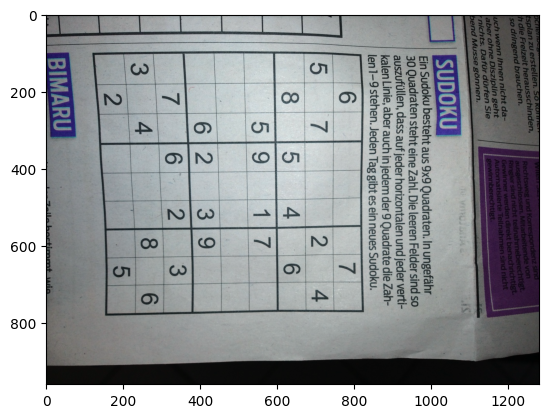

In [13]:
# Randomly select an image from the dataset 

folder=r"/home/princy/hello/myprojects/datasets/sudoku_dataset-master/images"

a=random.choice(os.listdir(folder))
print(a)
sudoku_a = cv2.imread(folder+'/'+a)
plt.figure()
plt.imshow(sudoku_a)
plt.show() 

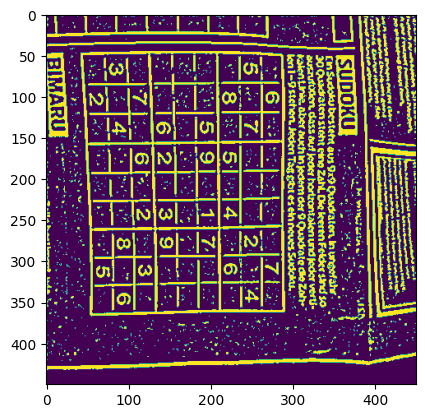

In [14]:
#Preprocessing image to be read
sudoku_a = cv2.resize(sudoku_a, (450,450))

# function to greyscale, blur and change the receptive threshold of image
def preprocess(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) 
    blur = cv2.GaussianBlur(gray, (3,3),6) 
    #blur = cv2.bilateralFilter(gray,9,75,75)
    threshold_img = cv2.adaptiveThreshold(blur,255,1,1,11,2)
    return threshold_img

threshold = preprocess(sudoku_a)

#let's look at what we have got
plt.figure()
plt.imshow(threshold)
plt.show()

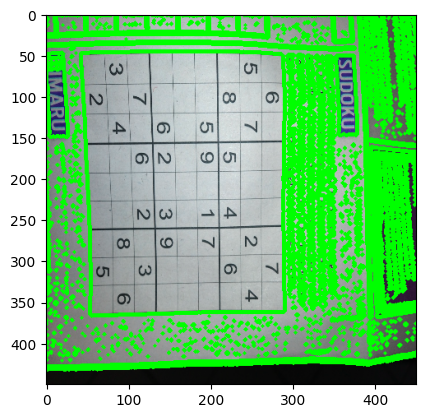

In [15]:
# Finding the outline of the sudoku puzzle in the image
contour_1 = sudoku_a.copy()
contour_2 = sudoku_a.copy()
contour, hierarchy = cv2.findContours(threshold,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
cv2.drawContours(contour_1, contour,-1,(0,255,0),3)

#let's see what we got
plt.figure()
plt.imshow(contour_1)
plt.show()

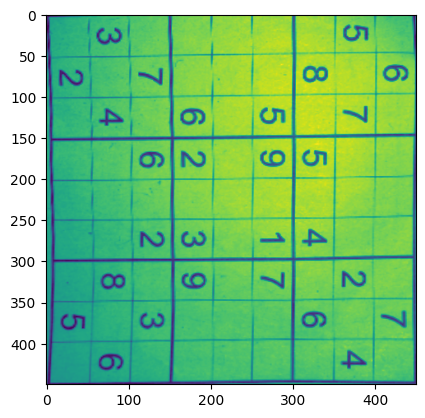

In [16]:
def main_outline(contour):
    biggest = np.array([])
    max_area = 0
    for i in contour:
        area = cv2.contourArea(i)
        if area >50:
            peri = cv2.arcLength(i, True)
            approx = cv2.approxPolyDP(i , 0.02* peri, True)
            if area > max_area and len(approx) ==4:
                biggest = approx
                max_area = area
    return biggest ,max_area

def reframe(points):
    points = points.reshape((4, 2))
    points_new = np.zeros((4,1,2),dtype = np.int32)
    add = points.sum(1)
    points_new[0] = points[np.argmin(add)]
    points_new[3] = points[np.argmax(add)]
    diff = np.diff(points, axis =1)
    points_new[1] = points[np.argmin(diff)]
    points_new[2] = points[np.argmax(diff)]
    return points_new

def splitcells(img):
    rows = np.vsplit(img,9)
    boxes = []
    for r in rows:
        cols = np.hsplit(r,9)
        for box in cols:
            boxes.append(box)
    return boxes


black_img = np.zeros((450,450,3), np.uint8)
biggest, maxArea = main_outline(contour)
if biggest.size != 0:
    biggest = reframe(biggest)
    cv2.drawContours(contour_2,biggest,-1, (0,255,0),10)
    pts1 = np.float32(biggest)
    pts2 = np.float32([[0,0],[450,0],[0,450],[450,450]])
    matrix = cv2.getPerspectiveTransform(pts1,pts2)  
    imagewrap = cv2.warpPerspective(sudoku_a,matrix,(450,450))
    imagewrap =cv2.cvtColor(imagewrap, cv2.COLOR_BGR2GRAY)
    
plt.figure()
plt.imshow(imagewrap)
plt.show()

In [17]:
height = imagewrap.shape[0]
width = imagewrap.shape[1]
step_height=height//9
step_width=width//9
sudoku = np.zeros((9,9))
i=0
for h in range(0,height-step_height,step_height):
    j=0
    for w in range(0, width-step_width, step_width):
        cell = np.array(imagewrap[h:h+step_height, w:w+step_width])
        cell = cv2.resize(cell, (32, 32))
        cell = cell / 255
        cell = cell.reshape(1, 32, 32, 1)
        cv2.imshow("image",cell)
        cv2.waitKey(0)
        
        cv2.destroyAllWindows()
        predictions = model.predict(cell)
        print(predictions)
        prob = np.max(predictions)
        if(prob>0.3):
            sudoku[i][j] = np.argmax(predictions)
        j+=1
    i+=1

print(sudoku)



qt.qpa.plugin: Could not find the Qt platform plugin "wayland" in "/home/princy/sandbox/lib/python3.9/site-packages/cv2/qt/plugins"


error: OpenCV(4.8.0) /io/opencv/modules/core/src/array.cpp:2494: error: (-206:Bad flag (parameter or structure field)) Unrecognized or unsupported array type in function 'cvGetMat'


: 

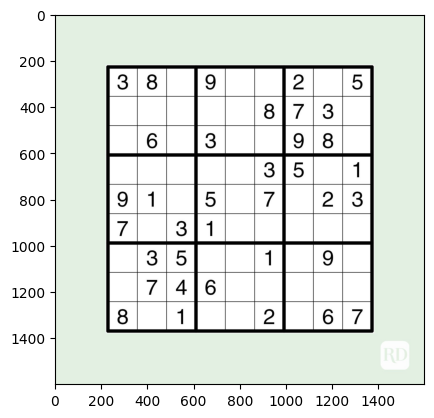

In [ ]:
# Importing puzzle to be solved
puzzle = cv2.imread("/home/princy/hello/myprojects/datasets/su.jpg")

#let's see what we got
plt.figure()
plt.imshow(puzzle)
plt.show()

In [ ]:
model.load_weights('/home/princy/hello/model/')

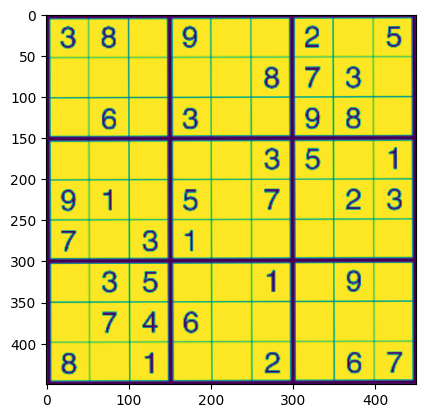

In [ ]:
# Resizing puzzle to be solved
puzzle = cv2.resize(puzzle, (450,450))
# Preprocessing Puzzle 
su_puzzle = preprocess(puzzle)

# Finding the outline of the sudoku puzzle in the image
su_contour_1= su_puzzle.copy()
su_contour_2= sudoku_a.copy()
su_contour, hierarchy = cv2.findContours(su_puzzle,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
cv2.drawContours(su_contour_1, su_contour,-1,(0,255,0),3)

black_img = np.zeros((450,450,3), np.uint8)
su_biggest, su_maxArea = main_outline(su_contour)
if su_biggest.size != 0:
    su_biggest = reframe(su_biggest)
    cv2.drawContours(su_contour_2,su_biggest,-1, (0,255,0),10)
    su_pts1 = np.float32(su_biggest)
    su_pts2 = np.float32([[0,0],[450,0],[0,450],[450,450]])
    su_matrix = cv2.getPerspectiveTransform(su_pts1,su_pts2)  
    su_imagewrap = cv2.warpPerspective(puzzle,su_matrix,(450,450))
    su_imagewrap =cv2.cvtColor(su_imagewrap, cv2.COLOR_BGR2GRAY)
    
plt.figure()
plt.imshow(su_imagewrap)
plt.show()

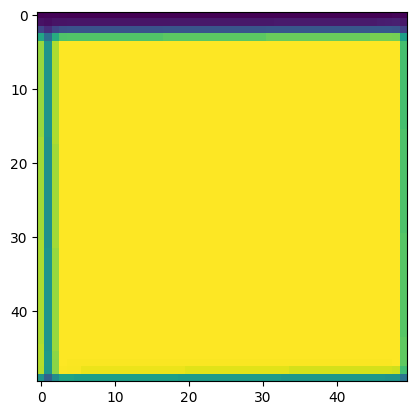

In [ ]:
sudoku_cell = splitcells(su_imagewrap)
#Let's have alook at the last cell
plt.figure()
plt.imshow(sudoku_cell[58])
plt.show()

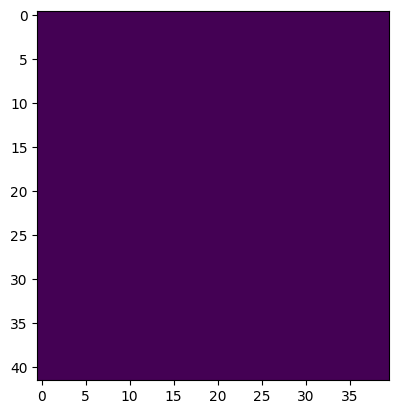

In [ ]:
# The sudoku_cell's output includes the boundaries this could lead to misclassifications by the model 
# I am cropping the cells to avoid that
# sneeking in a bit of PIL lib as cv2 was giving some weird error that i couldn't ward off

def CropCell(cells):
    Cells_croped = []
    for image in cells:
        
        img = np.array(image)
        img = img[4:46, 6:46]
        img = Image.fromarray(img)
        Cells_croped.append(img)
        
    return Cells_croped

sudoku_cell_croped= CropCell(sudoku_cell)
#Let's have alook at the last cell
plt.figure()
plt.imshow(sudoku_cell_croped[58])
plt.show()

In [ ]:
def read_cells(cell,model):

    result = []
    for image in cell:
        # preprocess the image as it was in the model 
        img = np.asarray(image)
        img = img[4:img.shape[0] - 4, 4:img.shape[1] -4]
        img = cv2.resize(img, (32, 32))
        img = img / 255
        img = img.reshape(1, 32, 32, 1)
        # getting predictions and setting the values if probabilities are above 65% 
        
        predictions = model.predict(img)
        classIndex = model.predict_classes(img)
        probabilityValue = np.amax(predictions)
        #classIndex = np.argmax(predictions,axis=1)

        
        if probabilityValue > 0.65:
            result.append(classIndex[0])
        else:
            result.append(0)
    return result

grid = read_cells(sudoku_cell_croped, model)
grid = np.asarray(grid)

1/1 [==============================] - 0s 30ms/step


AttributeError: 'Sequential' object has no attribute 'predict_classes'

In [ ]:
# Reshaping the grid to a 9x9 matrix

grid = np.reshape(grid,(9,9))
grid

array([[array([0, 0, 0, 1, 0, 0, 0, 0, 0, 0], dtype=int32),
        array([0, 0, 0, 0, 0, 0, 0, 0, 1, 0], dtype=int32), 0,
        array([0, 0, 0, 0, 0, 0, 0, 0, 0, 1], dtype=int32), 0, 0,
        array([0, 0, 1, 0, 0, 0, 0, 0, 0, 0], dtype=int32), 0,
        array([0, 0, 0, 0, 0, 1, 0, 0, 0, 0], dtype=int32)],
       [0, 0, 0, 0, 0,
        array([0, 0, 0, 0, 0, 0, 0, 0, 1, 0], dtype=int32),
        array([0, 0, 0, 0, 0, 0, 0, 1, 0, 0], dtype=int32),
        array([0, 0, 0, 1, 0, 0, 0, 0, 0, 0], dtype=int32), 0],
       [0, array([0, 0, 0, 0, 0, 0, 1, 0, 0, 0], dtype=int32), 0,
        array([0, 0, 0, 1, 0, 0, 0, 0, 0, 0], dtype=int32), 0, 0,
        array([0, 0, 0, 0, 0, 0, 0, 0, 0, 1], dtype=int32),
        array([0, 0, 0, 0, 0, 0, 0, 0, 1, 0], dtype=int32), 0],
       [0, 0, 0, 0, 0,
        array([0, 0, 0, 1, 0, 0, 0, 0, 0, 0], dtype=int32),
        array([0, 0, 0, 0, 0, 1, 0, 0, 0, 0], dtype=int32), 0,
        array([0, 1, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32)],
       [array([0,

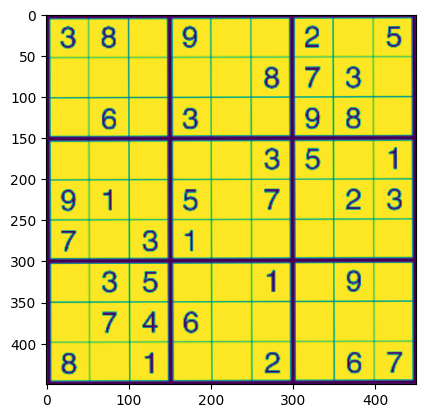

In [ ]:
#For compairing 
plt.figure()
plt.imshow(su_imagewrap)
plt.show()

In [ ]:
#This function finds the next box to solve 

def next_box(quiz):
    for row in range(9):
        for col in range(9):
            if quiz[row][col] == 0:
                return (row, col)
    return False

#Function to fill in the possible values by evaluating rows collumns and smaller cells

def possible (quiz,row, col, n):
    #global quiz
    for i in range (0,9):
        if quiz[row][i] == n and row != i:
            return False
    for i in range (0,9):
        if quiz[i][col] == n and col != i:
            return False
        
    row0 = (row)//3
    col0 = (col)//3
    for i in range(row0*3, row0*3 + 3):
        for j in range(col0*3, col0*3 + 3):
            if quiz[i][j]==n and (i,j) != (row, col):
                return False
    return True

#Recursion function to loop over untill a valid answer is found. 

def solve(quiz):
    val = next_box(quiz)
    if val is False:
        return True
    else:
        row, col = val
        for n in range(1,10): #n is the possible solution
            if possible(quiz,row, col, n):
                quiz[row][col]=n
                if solve(quiz):
                    return True 
                else:
                    quiz[row][col]=0
        return 
    
def Solved(quiz):
    for row in range(9):
        if row % 3 == 0 and row != 0:
            print("....................")

        for col in range(9):
            if col % 3 == 0 and col != 0:
                print("|", end=" ")

            if col == 8:
                print(quiz[row][col])
            else:
                print(str(quiz[row][col]) + " ", end="")


                
            

In [ ]:
solve(grid)

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [ ]:
if solve(grid):
    Solved(grid)
else:
    print("Solution don't exist. Model misread digits.")